# "To log10 or not to log10?" that is the question.

## Motivation
With the WHONDRS data spanning many orders of magnitude, it would seem like a good idea to apply a log10 (or other transform) on the target with the TransformedTargetRegressor option on `scikit-learn` models. This means that all trained ML models with this option will automatically read in data, transform it, train or predict, and then apply the inverse transform.

In an ideal world, we could use the [Yeo-Johnson transform](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html) because it does a good job handling a variety of cases.  In practice however, coupling the YJ transform (and other power transformers) to the hyperparameter optimization results in lots of internal NaN values that cause training to crash.  My guess is that the wide range of hyperparameters that we search through results in lots of off-the-wall values that the YJ transform is not prepared to handle.

So, in practice, I implemented my own [log10 transform/inverse](https://github.com/parallelworks/sl_core/blob/main/sample_inputs/superlearner_conf_TTR_mms_log10_neg.py) that uses both the log10 and **hard coded** (CAUTION!!!) limits to a MinMaxScaler for the WHONDRS data set. Since the MinMaxScaler is applied **after** the log10, this means that the MMS limits `[-2.0,4.0]` are orders of magnitude (i.e. 0.01 to 10000), not actual values. This notebook is designed to check how this log10 transformation performs compared to the standard approach which uses only (automated range) MinMaxScalers.

## Usage
To use this notebook, clone `dynamic-learning-rivers` (or another ML-archive repository).  Caution!!!! This code will switch branches in the repo to load the data and do side by side comparisions!!!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Number of independent SuperLearners
num_sl = 10
num_bins = 50

Updating files: 100% (237/237), done.
Switched to branch 'Oct-2023-log10'
Your branch is up to date with 'origin/Oct-2023-log10'.
Updating files: 100% (241/241), done.
Switched to branch 'Oct-2023'
Your branch is up to date with 'origin/Oct-2023'.


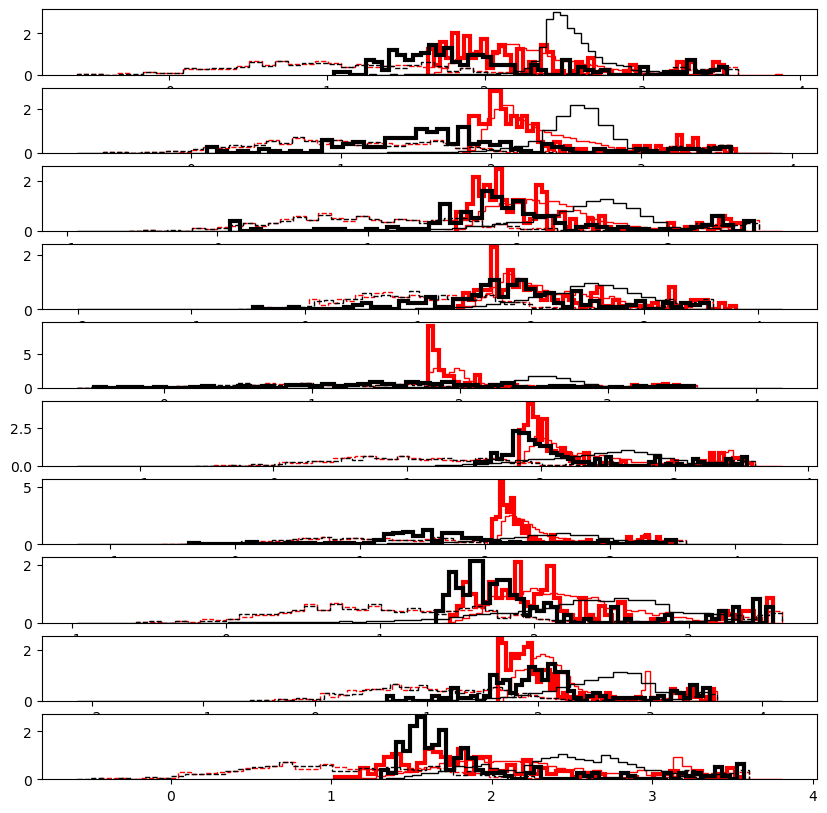

In [2]:
#!cd /pw/dev/dynamic-learning-rivers; git checkout test-y2023m09-w-log
!cd /pw/dev/dynamic-learning-rivers; git checkout Oct-2023-log10

# Load the first superlearner to initialize storage
train_target_w_log = pd.read_csv('/pw/dev/dynamic-learning-rivers/ml_models/sl_0/sl_scatter_train.csv')
test_target_w_log = pd.read_csv('/pw/dev/dynamic-learning-rivers/ml_models/sl_0/sl_scatter_test.csv')
predict_output_w_log = pd.read_csv("/pw/dev/dynamic-learning-rivers/ml_models/sl_0/sl_predictions.csv")
predict_output_w_log_sl_0 = predict_output_w_log
predict_output_w_log_CONUS = pd.read_csv("/pw/dev/dynamic-learning-rivers/output_data/filtered_predict_output.csv")

# Start a figure for plotting histograms
fig, ax = plt.subplots(10,1,figsize=(10,10))
n, bins, patches = ax[0].hist(
    np.log10(np.abs(predict_output_w_log['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment'])),
    num_bins, density=True, histtype="step", linestyle=('solid'), color=('r'))
n, bins, patches = ax[0].hist(
    np.log10(np.abs(train_target_w_log['target'])),
    num_bins, density=True, histtype="step", linestyle=('dashed'), color=('r'))
n, bins, patches = ax[0].hist(
    np.log10(np.abs(test_target_w_log['predicted'])),
    num_bins, density=True, histtype="step", linestyle=('solid'), color=('r'), linewidth=3)
    
# Loop over each SuperLearner (start counting with 1 since already loaded 0)
for ll in np.linspace(1,num_sl-1,num_sl-1):
    train = pd.read_csv('/pw/dev/dynamic-learning-rivers/ml_models/sl_'+str(int(ll))+'/sl_scatter_train.csv')
    test = pd.read_csv('/pw/dev/dynamic-learning-rivers/ml_models/sl_'+str(int(ll))+'/sl_scatter_test.csv')
    predict = pd.read_csv('/pw/dev/dynamic-learning-rivers/ml_models/sl_'+str(int(ll))+'/sl_predictions.csv')
    
    train_target_w_log = pd.concat([train_target_w_log, train])
    test_target_w_log = pd.concat([test_target_w_log, test])
    predict_output_w_log = pd.concat([predict_output_w_log, predict])
    
    n, bins, patches = ax[int(ll)].hist(
        np.log10(np.abs(predict['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment'])),
        num_bins, density=True, histtype="step", linestyle=('solid'), color=('r'))
    n, bins, patches = ax[int(ll)].hist(
        np.log10(np.abs(train['target'])),
        num_bins, density=True, histtype="step", linestyle=('dashed'), color=('r'))
    n, bins, patches = ax[int(ll)].hist(
        np.log10(np.abs(test['predicted'])),
        num_bins, density=True, histtype="step", linestyle=('solid'), color=('r'), linewidth=3)
    
    
#!cd /pw/dev/dynamic-learning-rivers; git checkout test-y2023m09-w-log
!cd /pw/dev/dynamic-learning-rivers; git checkout Oct-2023

# Load the first superlearner to initialize storage
train_target_n_log = pd.read_csv('/pw/dev/dynamic-learning-rivers/ml_models/sl_0/sl_scatter_train.csv')
test_target_n_log = pd.read_csv('/pw/dev/dynamic-learning-rivers/ml_models/sl_0/sl_scatter_test.csv')
predict_output_n_log = pd.read_csv("/pw/dev/dynamic-learning-rivers/ml_models/sl_0/sl_predictions.csv")
predict_output_n_log_sl_0 = predict_output_n_log
predict_output_n_log_CONUS = pd.read_csv("/pw/dev/dynamic-learning-rivers/output_data/filtered_predict_output.csv")

n, bins, patches = ax[0].hist(
    np.log10(np.abs(predict_output_n_log['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment'])),
    num_bins, density=True, histtype="step", linestyle=('solid'), color=('k'))
n, bins, patches = ax[0].hist(
    np.log10(np.abs(train_target_n_log['target'])),
    num_bins, density=True, histtype="step", linestyle=('dashed'), color=('k'))
n, bins, patches = ax[0].hist(
    np.log10(np.abs(test_target_n_log['predicted'])),
    num_bins, density=True, histtype="step", linestyle=('solid'), color=('k'), linewidth=3)

# Loop over each SuperLearner (start counting with 1 since already loaded 0)
for ll in np.linspace(1,num_sl-1,num_sl-1):
    train = pd.read_csv('/pw/dev/dynamic-learning-rivers/ml_models/sl_'+str(int(ll))+'/sl_scatter_train.csv')
    test = pd.read_csv('/pw/dev/dynamic-learning-rivers/ml_models/sl_'+str(int(ll))+'/sl_scatter_test.csv')
    predict = pd.read_csv('/pw/dev/dynamic-learning-rivers/ml_models/sl_'+str(int(ll))+'/sl_predictions.csv')
    
    train_target_n_log = pd.concat([train_target_n_log, train])
    test_target_n_log = pd.concat([test_target_n_log, test])
    predict_output_n_log = pd.concat([predict_output_n_log, predict])
    
    n, bins, patches = ax[int(ll)].hist(
        np.log10(np.abs(predict['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment'])),
        num_bins, density=True, histtype="step", linestyle=('solid'), color=('k'))
    n, bins, patches = ax[int(ll)].hist(
        np.log10(np.abs(train['target'])),
        num_bins, density=True, histtype="step", linestyle=('dashed'), color=('k'))
    n, bins, patches = ax[int(ll)].hist(
        np.log10(np.abs(test['predicted'])),
        num_bins, density=True, histtype="step", linestyle=('solid'), color=('k'), linewidth=3)

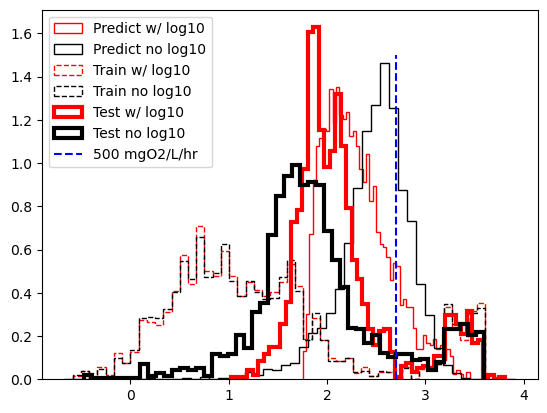

In [3]:
# Above we plotted each SuperLearner iteration separately.
# Now, plot the overall, merged distributions.

fig, ax = plt.subplots(1,1)
n, bins, patches = ax.hist(
    np.log10(np.abs(predict_output_w_log_CONUS['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment'])),
    num_bins, density=True, histtype="step", linestyle=('solid'), color=('r'))
n, bins, patches = ax.hist(
    np.log10(np.abs(predict_output_n_log_CONUS['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment'])),
    num_bins, density=True, histtype="step", linestyle=('solid'), color=('k'))
n, bins, patches = ax.hist(
    np.log10(np.abs(train_target_w_log['target'])),
    num_bins, density=True, histtype="step", linestyle=('dashed'), color=('r'))
n, bins, patches = ax.hist(
    np.log10(np.abs(train_target_n_log['target'])),
    num_bins, density=True, histtype="step", linestyle=('dashed'), color=('k'))
n, bins, patches = ax.hist(
    np.log10(np.abs(test_target_w_log['predicted'])),
    num_bins, density=True, histtype="step", linestyle=('solid'), color=('r'), linewidth=3)
n, bins, patches = ax.hist(
    np.log10(np.abs(test_target_n_log['predicted'])),
    num_bins, density=True, histtype="step", linestyle=('solid'), color=('k'), linewidth=3)

# Add the 500 line for visualizing where the cut off is:
ax.plot([np.log10(500.0),np.log10(500.0)],[0,1.5],'b--')
ax.legend(['Predict w/ log10','Predict no log10','Train w/ log10','Train no log10','Test w/ log10','Test no log10','500 mgO2/L/hr'])

In [4]:
# What is the percent of predicted positive respiration rates?

def get_percent_negative(df_in,target_name='Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment'):
    num_pos = np.shape(
        df_in[df_in[target_name] > 0])[0]
    num_all = np.shape(df_in)[0]
    return 100.0*num_pos/num_all

print('Predict w/ log10: '+str(get_percent_negative(predict_output_w_log)))
print('Predict no log10: '+str(get_percent_negative(predict_output_n_log)))

print('Train predict w/ log10: '+str(get_percent_negative(train_target_w_log,'predicted')))
print('Train predict no log10: '+str(get_percent_negative(train_target_n_log,'predicted')))


#np.shape(test_target_n_log)
#num_pos = np.shape(
#    predict_output_n_log[
#        predict_output_n_log['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment'] > 0])[0]

Predict w/ log10: 0.0
Predict no log10: 5.69541422909983
Train predict w/ log10: 0.0
Train predict no log10: 3.2874015748031495


(array([1.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 2.100e+01, 4.600e+01,
        4.700e+01, 6.500e+01, 3.000e+01, 1.487e+03]),
 array([-6412.31170545, -5772.13868853, -5131.96567161, -4491.79265468,
        -3851.61963776, -3211.44662084, -2571.27360392, -1931.100587  ,
        -1290.92757008,  -650.75455316,   -10.58153624]),
 <BarContainer object of 10 artists>)

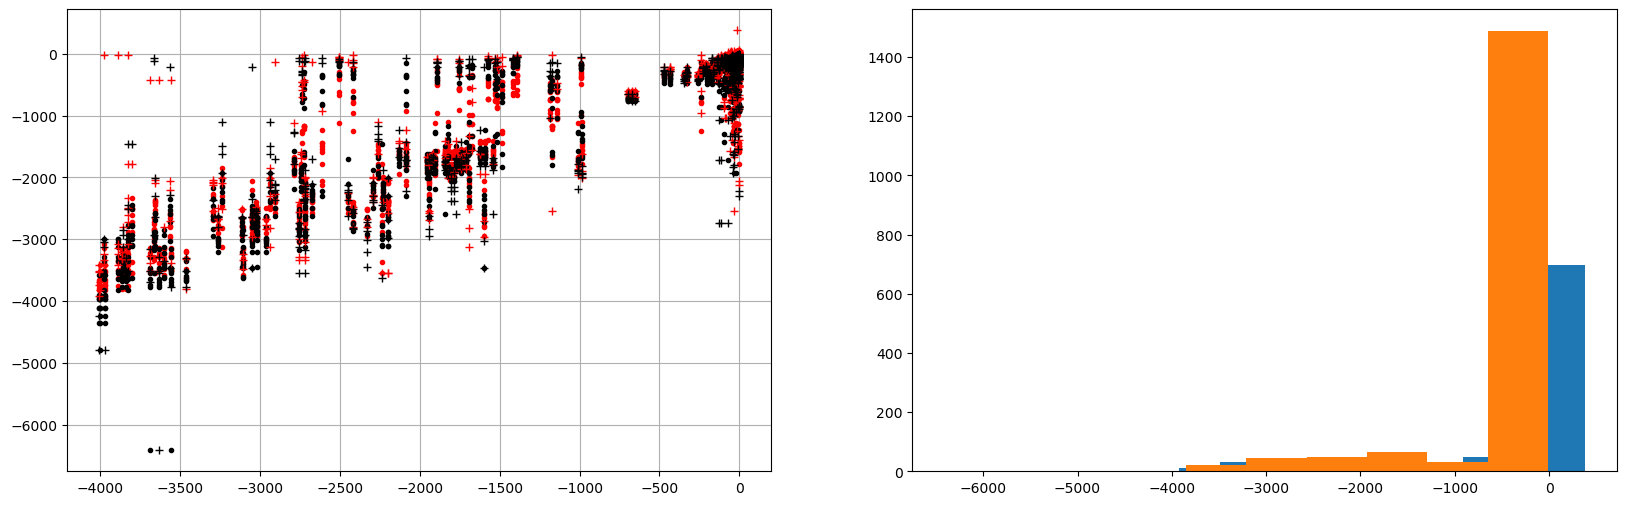

In [5]:
fig, [ax0,ax1] = plt.subplots(1,2,figsize=(20,6))
ax0.plot(train_target_n_log['target'],train_target_n_log['predicted'],'r.')
ax0.plot(train_target_w_log['target'],train_target_w_log['predicted'],'k.')
ax0.plot(test_target_n_log['target'],test_target_n_log['predicted'],'r+')
ax0.plot(test_target_w_log['target'],test_target_w_log['predicted'],'k+')
ax0.grid()

ax1.hist(test_target_n_log['predicted'])
ax1.hist(test_target_w_log['predicted'])

Scatter plot of target versus predicted values. Hard to tell which is better from the scatter.  But, what is obvious is that the custom transformer enforces that all predictions are negative.

Let's run correlations on the whole data set as well as the high and low values (-500 is a great cutoff).

In [6]:
train_w_log_small = np.squeeze(train_target_w_log[train_target_w_log['target'] >= -500.0])
test_w_log_small = np.squeeze(test_target_w_log[test_target_w_log['target'] >= -500.0])

train_n_log_small = np.squeeze(train_target_n_log[train_target_n_log['target'] >= -500.0])
test_n_log_small = np.squeeze(test_target_n_log[test_target_n_log['target'] >= -500.0])

train_w_log_large = np.squeeze(train_target_w_log[train_target_w_log['target'] < -500.0])
test_w_log_large = np.squeeze(test_target_w_log[test_target_w_log['target'] < -500.0])

train_n_log_large = np.squeeze(train_target_n_log[train_target_n_log['target'] < -500.0])
test_n_log_large = np.squeeze(test_target_n_log[test_target_n_log['target'] < -500.0])

# Function to return correlation coefficient for two columns in a dataframe.
def c2c_r2(input):
    corrcoeff = np.min(np.min(np.corrcoef(input['target'],y=input['predicted'])))
    return np.multiply(corrcoeff,corrcoeff)

# Function to return correlation coefficient for two columns in a dataframe in log10 space.
def c2c_r2_log(input):
    c1 = np.log10(np.abs(input['target']))
    c2 = np.log10(np.abs(input['predicted']))
    corrcoeff = np.min(np.min(np.corrcoef(c1,y=c2)))
    return np.multiply(corrcoeff,corrcoeff)

In [7]:
print("R2 in normal units")
print("Data set -------- Whole data set -------------- Small values -------------- Large values -------------")

print('Train n log --- '+
      str(c2c_r2(train_target_n_log))+' --- '+
      str(c2c_r2(train_n_log_small))+' --- '+
      str(c2c_r2(train_n_log_large))
     )

print('Test n log --- '+
      str(c2c_r2(test_target_n_log))+' --- '+
      str(c2c_r2(test_n_log_small))+' --- '+
      str(c2c_r2(test_n_log_large))
     )

print('Train w log --- '+
      str(c2c_r2(train_target_w_log))+' --- '+
      str(c2c_r2(train_w_log_small))+' --- '+
      str(c2c_r2(train_w_log_large))
     )

print('Test w log --- '+
      str(c2c_r2(test_target_w_log))+' --- '+
      str(c2c_r2(test_w_log_small))+' --- '+
      str(c2c_r2(test_w_log_large))
     )

print(" ")
print("R2 in log10 space")
print("Data set -------- Whole data set -------------- Small values -------------- Large values -------------")

print('Train n log --- '+
      str(c2c_r2_log(train_target_n_log))+' --- '+
      str(c2c_r2_log(train_n_log_small))+' --- '+
      str(c2c_r2_log(train_n_log_large))
     )

print('Test n log --- '+
      str(c2c_r2_log(test_target_n_log))+' --- '+
      str(c2c_r2(test_n_log_small))+' --- '+
      str(c2c_r2(test_n_log_large))
     )

print('Train w log --- '+
      str(c2c_r2_log(train_target_w_log))+' --- '+
      str(c2c_r2_log(train_w_log_small))+' --- '+
      str(c2c_r2_log(train_w_log_large))
     )

print('Test w log --- '+
      str(c2c_r2_log(test_target_w_log))+' --- '+
      str(c2c_r2_log(test_w_log_small))+' --- '+
      str(c2c_r2_log(test_w_log_large))
     )

R2 in normal units
Data set -------- Whole data set -------------- Small values -------------- Large values -------------
Train n log --- 0.9220574112766906 --- 0.11881219748198167 --- 0.7186879355839184
Test n log --- 0.7104078147948514 --- 0.038017895586286835 --- 0.28376155951426474
Train w log --- 0.8818270356715233 --- 0.1622736104219119 --- 0.6322919498412857
Test w log --- 0.6798790611831783 --- 0.04857163343712037 --- 0.2818070678905428
 
R2 in log10 space
Data set -------- Whole data set -------------- Small values -------------- Large values -------------
Train n log --- 0.6994145523450118 --- 0.2870127449045984 --- 0.5541453802880492
Test n log --- 0.4935154754234853 --- 0.038017895586286835 --- 0.28376155951426474
Train w log --- 0.6997618762446675 --- 0.28200263447806645 --- 0.39039133063246384
Test w log --- 0.5522986244325557 --- 0.20355047806973933 --- 0.13529298029690334


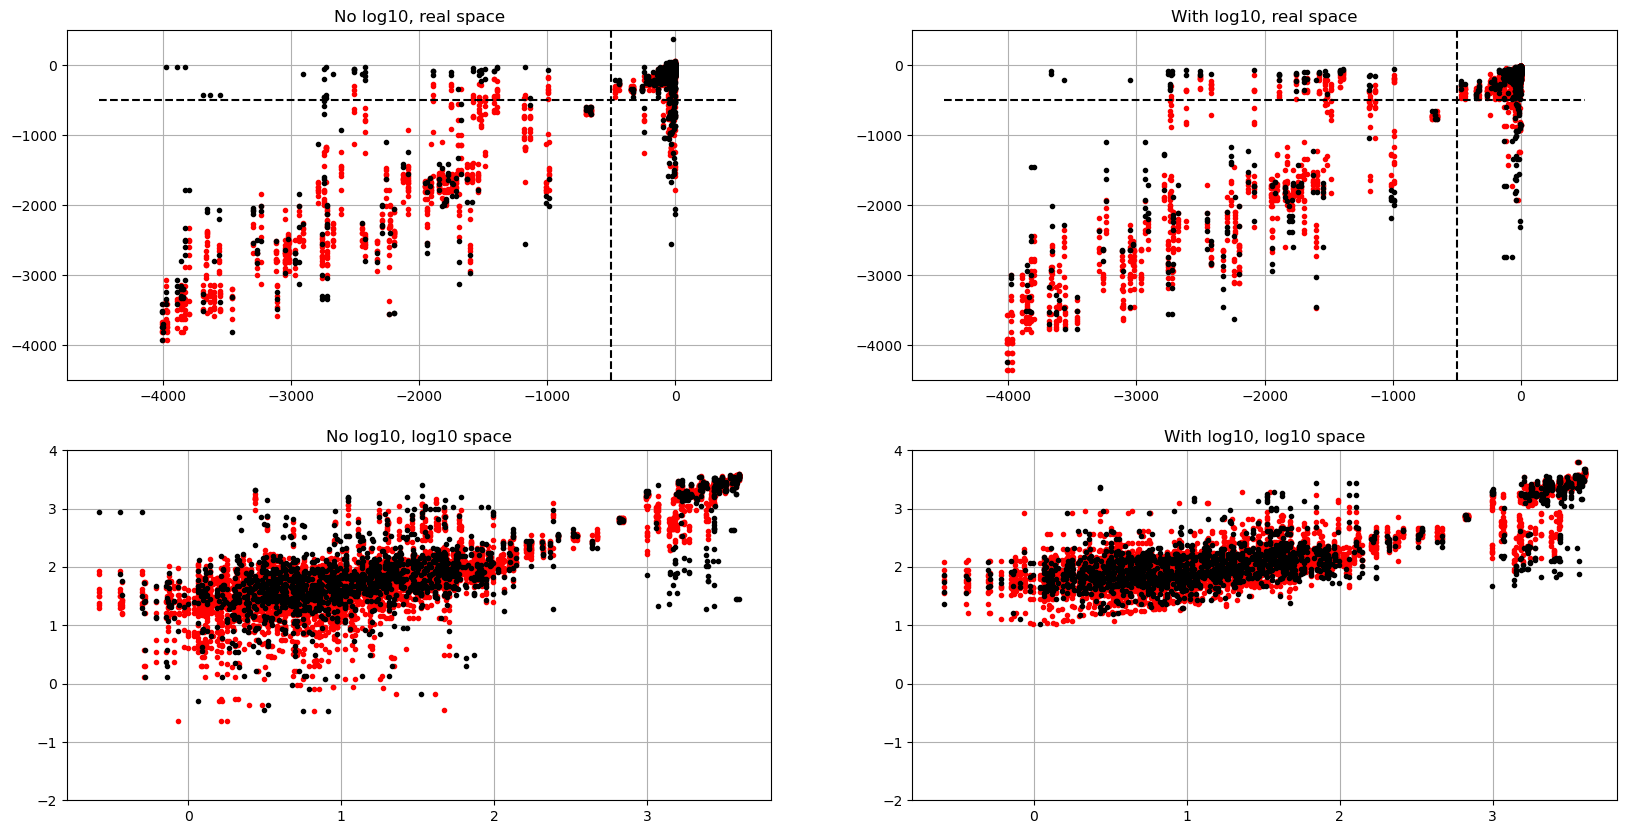

In [8]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2,2,figsize=(20,10))
ax1.plot(
    train_target_n_log['target'],
    train_target_n_log['predicted'],'r.')

ax1.plot(
    test_target_n_log['target'],
    test_target_n_log['predicted'],'k.')
ax1.grid()
ax1.set_ylim([-4500, 500])
ax1.title.set_text('No log10, real space')
ax1.plot([-4500, 500],[-500, -500],'k--')
ax1.plot([-500, -500],[-4500, 500],'k--')

ax2.plot(
    train_target_w_log['target'],
    train_target_w_log['predicted'],'r.')

ax2.plot(
    test_target_w_log['target'],
    test_target_w_log['predicted'],'k.')
ax2.grid()
ax2.set_ylim([-4500, 500])
ax2.title.set_text('With log10, real space')
ax2.plot([-4500, 500],[-500, -500],'k--')
ax2.plot([-500, -500],[-4500, 500],'k--')

ax3.plot(
    np.log10(np.abs(train_target_n_log['target'])),
    np.log10(np.abs(train_target_n_log['predicted'])),'r.')

ax3.plot(
    np.log10(np.abs(test_target_n_log['target'])),
    np.log10(np.abs(test_target_n_log['predicted'])),'k.')
ax3.grid()
ax3.set_ylim([-2, 4])
ax3.title.set_text('No log10, log10 space')

ax4.plot(
    np.log10(np.abs(train_target_w_log['target'])),
    np.log10(np.abs(train_target_w_log['predicted'])),'r.')

ax4.plot(
    np.log10(np.abs(test_target_w_log['target'])),
    np.log10(np.abs(test_target_w_log['predicted'])),'k.')
ax4.grid()
ax4.set_ylim([-2, 4])
ax4.title.set_text('With log10, log10 space')

## So what about classifying values - how many false classifications are there in each model?

For example, if we are most interested in determining whether we have a hot spot or not (as opposed to predicting the actual value of the data), how well do these two models perform?

In [9]:
# Find the number of false large in small data
print('Percent of false large predictions in small data w log: '+
      str(100.0*np.shape(test_w_log_small[test_w_log_small['predicted'] < -500])[0]/np.shape(test_w_log_small)[0]))

print('Percent of false large predictions in small data no log: '+
      str(100.0*np.shape(test_n_log_small[test_n_log_small['predicted'] < -500])[0]/np.shape(test_n_log_small)[0]))

print('Percent of false small predictions in large data w log: '+
      str(100.0*np.shape(test_w_log_large[test_w_log_large['predicted'] >= -500])[0]/np.shape(test_w_log_large)[0]))

print('Percent of false small predictions in large data no log: '+
      str(100.0*np.shape(test_n_log_large[test_n_log_large['predicted'] >= -500])[0]/np.shape(test_n_log_large)[0]))

Percent of false large predictions in small data w log: 2.8649386084583903
Percent of false large predictions in small data no log: 3.8539553752535496
Percent of false small predictions in large data w log: 23.931623931623932
Percent of false small predictions in large data no log: 21.266968325791854
